# Graded Exercise 1: Quadratic integrate and fire

first name: Diogo

last name: Ramalho

sciper: 319927

date: ...

*Your teammate*

first name of your teammate: Joachim

last name of your teammate: Dunant

sciper of your teammate: 262314


Note: You are allowed to discuss the concepts with your class mates. You are not allowed to share code. You have to understand every line of code you write in this notebook. We will ask you questions about your submission during a fraud detection session during the last week of the semester.


** Submission **

Rename this notebook to Ex1_FirstName_LastName_Sciper.ipynb and upload that single file on moodle before the deadline.

** Link to the exercise **

https://lcn-neurodynex-exercises.readthedocs.io/en/latest/exercises/exponential-integrate-and-fire.html

## 1.1 Quadratic Integrate and Fire neuron [20 points]
This exercise is not available online. All information is given here.

1.1.1 Read the book chapter about the quadratic integrate and fire neuron
https://neuronaldynamics.epfl.ch/online/Ch5.S3.html

[0 point]

1.1.2 Implement the quadratic integrate and fire neuron in Brian2:

* Follow the [source]-link in the documentation to get the Python source code of the exponential integrate and fire neuron. https://lcn-neurodynex-exercises.readthedocs.io/en/latest/modules/neurodynex3.exponential_integrate_fire.html
* Find the one function that implements the exponential LIF. Copy that function into this notebook. Rename the function, change it's parameters and modify the dynamics from the exponential to the quadratic equation (Equation 5.16 in the book).

[6 points]

1.1.3 Call your function: 
As above, inject a current into your neuron and plot the response.


[2 points]

1.1.4 Approximate the exponential model
* The quadratic model has three parameters: a0, v_rest and vc (note that this v_rest is different from the v_rest of the exponential model). They can be chosen such that the quadratic model approximates the exponential model. Read the box "Example: Approximating the exponential integrate-and-fire" in chapter http://neuronaldynamics.epfl.ch/online/Ch5.S3.html and make sure you understand figure 5.8.
* On paper, find the equations that express the parameters a0, v_rest and vc (in terms of the parameters of the exponential model) such that the two models are matched (in value, slope and curvature) at the rheobase threshold.
* In code, compute the values of a0, v_rest and vc using the values provided in the exp_IF module.


[4 points]

1.1.5 Simulate the quadratic- and the exponential model
* Inject the same current into an exponential- and into your (matched) quadratic model. Set the current duration to 1 second and the amplitude to I_Rh + 0.030 * b2.namp  (I_Rh as computed in exercise 3.1). Simulate for 1 second and plot the voltage responses.


[3 point]

1.1.6 Discuss your observation


[5 point]


# Solutions

## 1.1.2 Implement the quadratic integrate and fire model in Brian2

In [83]:
import neurodynex3.exponential_integrate_fire.exp_IF as exp_IF
from neurodynex3.tools import plot_tools, input_factory
import brian2 as b2

b2.defaultclock.dt = 0.05 * b2.ms


# default values for quadratic model
MEMBRANE_TIME_SCALE_tau = 12.0 * b2.ms
MEMBRANE_RESISTANCE_R = 20.0 * b2.Mohm
A_0 = 10 / b2.volt
V_CRITICAL = -35.0 * b2.mV 
V_REST = -65.0 * b2.mV
V_RESET = -60.0 * b2.mV
RHEOBASE_THRESHOLD_v_rh = -55.0 * b2.mV
SHARPNESS_delta_T = 2.0 * b2.mV

# a technical threshold to tell the algorithm when to reset vm to v_reset
FIRING_THRESHOLD_v_spike = -20.0 * b2.mV



#Implements the dynamics of the quadratic Integrate-and-fire model
def simulate_quadratic_IF_neuron(
        tau=MEMBRANE_TIME_SCALE_tau,
        R=MEMBRANE_RESISTANCE_R,
        a_0 = A_0,
        v_c = V_CRITICAL,
        v_rest=V_REST,
        v_reset=V_RESET,
        v_spike=FIRING_THRESHOLD_v_spike,
        I_stim=input_factory.get_zero_current(),
        simulation_time=200 * b2.ms):
    """

    Args:
        tau (Quantity): Membrane time constant
        R (Quantity): Membrane resistance
        a_0 (Float): Constant
        v_c (Quantity): Critical potential
        v_rest (Quantity): Resting potential
        v_reset (Quantity): Reset value (vm after spike)
        v_spike (Quantity) : voltage threshold for the spike condition
        I_stim (TimedArray): Input current
        simulation_time (Quantity): Duration for which the model is simulated

    Returns:
        (voltage_monitor, spike_monitor):
        A b2.StateMonitor for the variable "v" and a b2.SpikeMonitor
    """

    eqs = """
    dv/dt = (a_0*(v-v_rest)*(v-v_c) + R * I_stim(t,i))/(tau) : volt
    """
    
    neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset", threshold="v>v_spike", method="euler")

    neuron.v = v_rest
    # monitoring membrane potential of neuron and injecting current
    voltage_monitor = b2.StateMonitor(neuron, ["v"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)

    # run the simulation
    net = b2.Network(neuron, voltage_monitor, spike_monitor)
    net.run(simulation_time)

    return voltage_monitor, spike_monitor

## 1.1.3 Call your function: As above, inject a current into your neuron and plot the response.

nr of spikes: 4


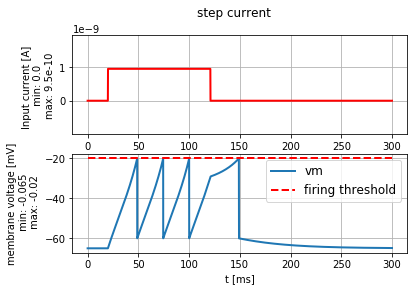

In [84]:
input_current = input_factory.get_step_current(
    t_start=20, t_end=120, unit_time=b2.ms, amplitude=0.95 * b2.namp)

state_monitor, spike_monitor = simulate_quadratic_IF_neuron(
    I_stim=input_current, simulation_time=300*b2.ms)

plot_tools.plot_voltage_and_current_traces(
    state_monitor, input_current,title="step current",
    firing_threshold=FIRING_THRESHOLD_v_spike)
print("nr of spikes: {}".format(spike_monitor.count[0]))

## 1.1.4 Approximate the exponential model

In [85]:
import math

A_0 = 1 / (2 * exp_IF.SHARPNESS_delta_T)
print("A_0:")
print(A_0)

V_rest = exp_IF.RHEOBASE_THRESHOLD_v_rh - math.sqrt(2 * exp_IF.SHARPNESS_delta_T * (exp_IF.RHEOBASE_THRESHOLD_v_rh - exp_IF.V_REST - exp_IF.SHARPNESS_delta_T)) * b2.volt
print("\nV_rest:")
print(V_rest)

V_C = exp_IF.RHEOBASE_THRESHOLD_v_rh + math.sqrt(2 * exp_IF.SHARPNESS_delta_T * (exp_IF.RHEOBASE_THRESHOLD_v_rh - exp_IF.V_REST - exp_IF.SHARPNESS_delta_T)) * b2.volt 
print("\nV_C:")
print(V_C)

A_0:
250. m^-2 kg^-1 s^3 A

V_rest:
-60.65685425 mV

V_C:
-49.34314575 mV


## 1.1.5 Simulate the quadratic- and the exponential model

nr of spikes for quadratic model: 11


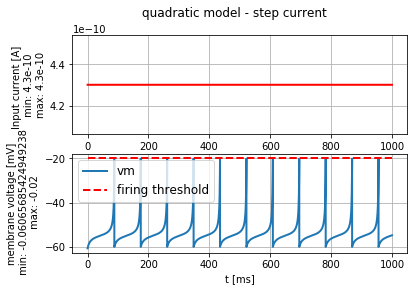

In [86]:
import matplotlib.pyplot as plt


# define the current to inject
input_current = input_factory.get_step_current(
    t_start=0, t_end=1000, unit_time=b2.ms, amplitude=0.43 * b2.namp)


# inject current into quadratic model
quad_state_monitor, quad_spike_monitor = simulate_quadratic_IF_neuron(
    a_0 = A_0, v_c = V_C, v_rest = V_rest,
    I_stim=input_current, simulation_time=1000*b2.ms)


# Plot the voltage response to the injected current in quadratic model
plot_tools.plot_voltage_and_current_traces(
    quad_state_monitor, input_current,title="quadratic model - step current",
    firing_threshold=FIRING_THRESHOLD_v_spike)
print("nr of spikes for quadratic model: {}".format(quad_spike_monitor.count[0]))


nr of spikes for exponential model: 12


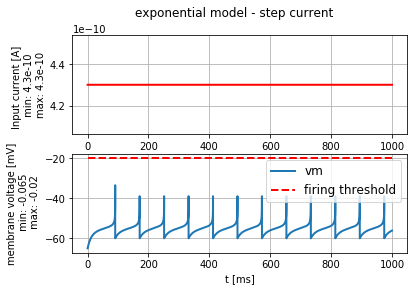

In [87]:
# inject current into exponential model
exp_state_monitor, exp_spike_monitor = exp_IF.simulate_exponential_IF_neuron(v_reset=V_RESET,
    I_stim=input_current, simulation_time=1000*b2.ms)

# Plot the voltage response to the injected current in exponential model
plot_tools.plot_voltage_and_current_traces(
    exp_state_monitor, input_current,title="exponential model - step current",
    firing_threshold=FIRING_THRESHOLD_v_spike)
print("nr of spikes for exponential model: {}".format(exp_spike_monitor.count[0]))

nr of spikes for quadratic model: 11


WARNING    /Users/diogoramalho/opt/anaconda3/envs/bmnn/lib/python3.8/site-packages/neurodynex3/tools/plot_tools.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis_c = plt.subplot(211)
 [py.warnings]
WARNING    /Users/diogoramalho/opt/anaconda3/envs/bmnn/lib/python3.8/site-packages/neurodynex3/tools/plot_tools.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis_v = plt.subplot(212)
 [py.warnings]


nr of spikes for exponential model: 12


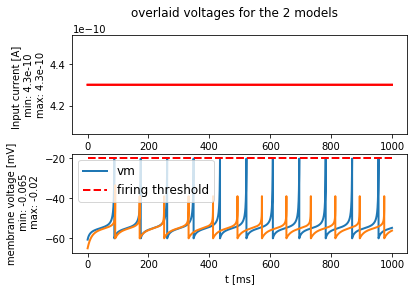

In [88]:
import matplotlib.pyplot as plt


# inject current into quadratic model
quad_state_monitor, quad_spike_monitor = simulate_quadratic_IF_neuron(
    a_0 = A_0, v_c = V_C, v_rest = V_rest,
    I_stim=input_current, simulation_time=1000*b2.ms)


# Plot the voltage response to the injected current in quadratic model
plot_tools.plot_voltage_and_current_traces(
    quad_state_monitor, input_current,title="quadratic model - step current",
    firing_threshold=FIRING_THRESHOLD_v_spike)
print("nr of spikes for quadratic model: {}".format(quad_spike_monitor.count[0]))

# inject current into exponential model
exp_state_monitor, exp_spike_monitor = exp_IF.simulate_exponential_IF_neuron(v_reset=V_RESET,
    I_stim=input_current, simulation_time=1000*b2.ms)

# Plot the voltage response to the injected current in exponential model
plot_tools.plot_voltage_and_current_traces(
    exp_state_monitor, input_current,title="overlaid voltages for the 2 models",
    firing_threshold=FIRING_THRESHOLD_v_spike)
print("nr of spikes for exponential model: {}".format(exp_spike_monitor.count[0]))

## 1.1.6 Discuss your observation

Explain your observations here. Qualitatively compare the voltage traces of the exponential- and the quadratic model. Is the number of spikes the same for the two models?

1 - In order to better understand the dynamics of the 2 models, we plotted the change in voltage according to time in terms of the voltage for the exponential model and the matched quadratic model, as can be seen below. From there we can observe that when the voltage is below the rheobase threshold, the quadratic model will increase its voltage faster as du/dt is higher. This only changes when the voltage is equal to the rheobase threshold, where the exponential model changes from the linear phase to the exponential phase.

2 - When the voltage is equal to Urest, as du/dt is smaller for the exponential model, it takes more time for it to reach the Rh threshold than for the quadratic model. However, when it does it increases the voltage much faster.

3 - After the first spike, the voltage is reset to U_reset (-60mV) that is greater than U_rest (-65mV), which means that the time the exponential model now takes to reach its exponential phase is lower, and so the time it takes since it is reset until it emits a spike is also lower. This also happens in the quadratic model, however the decrease in the period is higher for the exponential model.

4 - We observe that the exponential model has 12 spikes, while the quadratic model has 11, one less.

5 - We also observed that if the reset potential and the resting potential were the same, the models would have a more similar period, almost the same.

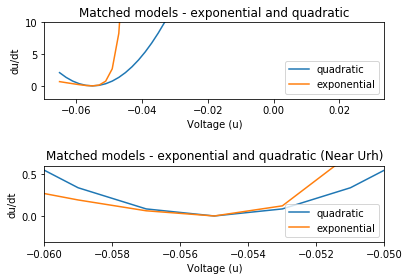

In [95]:
v_rest = -65.0 * b2.mV
v_rheobase = -55.0 * b2.mV
delta_T = 2.0 * b2.mV
tau = 12.0 * b2.ms
R = 20.0 * b2.Mohm
I = 0.403 * b2.namp

QUAD = []
EXP = []


voltages = [i * b2.mV for i in range(-65, 30, 2)]


for v in voltages:
    EXP.append((-(v-v_rest) + delta_T * math.exp((v-v_rheobase)/delta_T) + R*I)/tau)
    QUAD.append((A_0*(v-V_rest)*(v-V_C) + R*I) / (tau))


fig, axs = plt.subplots(2)

axs[0].plot(voltages, QUAD, label='quadratic')
axs[0].plot(voltages, EXP, label='exponential')
axs[0].legend(loc="lower right")
axs[0].set_xlabel("Voltage (u)")
axs[0].set_ylabel("du/dt")
axs[0].title.set_text("Matched models - exponential and quadratic")
axs[0].set_ylim(-2,10)

axs[1].plot(voltages, QUAD, label='quadratic')
axs[1].plot(voltages, EXP, label='exponential')
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Voltage (u)")
axs[1].set_ylabel("du/dt")
axs[1].title.set_text("Matched models - exponential and quadratic (Near Urh)")
axs[1].set_ylim(-0.3,0.6)
axs[1].set_xlim(-0.06,-0.05)

fig.tight_layout(h_pad=2)

# Ex. 2. AdEx: the Adaptive Exponential Integrate-and-Fire model

Use function [`AdEx.simulate_AdEx_neuron()`](https://lcn-neurodynex-exercises.readthedocs.io/en/latest/modules/neurodynex3.adex_model.html) to run the model for different input currents and different parameters. Get started by running the following script:

In [4]:
%matplotlib inline
import brian2 as b2
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, input_factory


## 2.1. Exercise: Adaptation and firing patterns [13 points]

We have implemented an Exponential Integrate-and-Fire model with a single adaptation current
$\begin{split}\left[\begin{array}{ccll}
{\displaystyle \tau_m \frac{du}{dt}} &=& -(u-u_{rest}) + \Delta_T exp(\frac{u-\vartheta_{rh}}{\Delta_T}) - R w + R I(t) \\[.2cm]
{\displaystyle \tau_w \frac{dw}{dt}} &=& a (u-u_{rest}) -w  + b \tau_w \sum_{t^{(f)}} \delta (t - t^{(f)})
 \\[.2cm]
\end{array}\right.\end{split}$

- When you simulate the model with the default parameters, it produces the voltage trace shown above. Describe that firing pattern. Use the terminology of Fig. 6.1 in [Chapter 6.1](https://neuronaldynamics.epfl.ch/online/Ch6.S1.html) [max 2 lines, 1 point]

- Call the function `AdEx.simulate_AdEx_neuron()` with different parameters and try to create adapting, bursting and irregular firing patterns. Table 6.1 in Chapter 6.1 provides a starting point for your explorations. 

**Note:** If you want to set a parameter to 0, Brian still expects a unit. Therefore use `a=0*b2.nS` instead of `a=0`.

If you do not specify any parameter, the following default values are used:

`MEMBRANE_TIME_SCALE_tau_m = 5 * b2.ms`

`MEMBRANE_RESISTANCE_R = 500*b2.Mohm`

`V_REST = -70.0 * b2.mV`

`V_RESET = -51.0 * b2.mV`

`RHEOBASE_THRESHOLD_v_rh = -50.0 * b2.mV`

`SHARPNESS_delta_T = 2.0 * b2.mV`

`ADAPTATION_VOLTAGE_COUPLING_a = 0.5 * b2.nS`

`ADAPTATION_TIME_CONSTANT_tau_w = 100.0 * b2.ms`

`SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = 7.0 * b2.pA`

[2 points]

In [ ]:
# adapting 
% matplotlib inline
import brian2 as b2

[2 points]

In [ ]:
# bursting firing pattern from book

[2 points]

In [ ]:
# irregular firing pattern

[2 points]

In [ ]:
# adapting firing pattern

[2 points]

In [ ]:
# bursting firing pattern

[2 points]

In [ ]:
# irregular firing pattern

## 2.2. Exercise: phase plane and nullclines [12 points]

First, try to get some intuition on shape of nullclines by plotting or simply sketching them on a piece of paper and answering the following questions.
Plot or sketch the u- and w- nullclines of the AdEx model (`I(t) = 0`)
- What is the direction of the flow arrows on the u-nullcline ?
- How do the nullclines change with respect to `a`?
- What is the interpretation of parameter `b`?
- How do flow arrows change as tau_w gets bigger?

[max 10 lines, 4 points]

Take `a = 0`. Find a set of parameters such that, by changing `b` only, we can see two qualitatively different firing patterns. Simulate these two patterns and write their names.

[4 points]

In [2]:
# First firing pattern (simulation [2 points] and pattern name [2 points])

[4 points]

In [1]:
# Second firing pattern (simulation [2 points] and pattern name [2 points])